In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import mpld3
mpld3.enable_notebook()
import pandas as pd
import lmfit
import numpy as np
import csv

In [2]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [3]:
N = 1_300_000_000 #Total Population
D = 3.0 #number of days an infected person has and can spread the disease
gamma = 1.0 / D #the proportion of infected recovering per day
delta = 1.0 / 9.0  # incubation period
alpha = 0.028  # 2.8% death rate
rho = 1/9  # 9 days from infection until death

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days,R_0_start, k, x0, R_0_end):
    
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    S0, E0, I0, R0, D0 = N-1.0, 1.0, 0.0, 0.0, 0.0  # initial conditions: one exposed
    y0 = S0, E0, I0, R0, D0 # Initial conditions vector
    t = np.linspace(0, days-1, days)
    
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
    S, E, I, R, D = ret.T
    
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    
    return t,S,E,I,R,D,R_0_over_time

In [4]:
state="National"
confirmed=[]
with open('nation_level_daily_latest.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        confirmed.append(float(row[2]))

series = np.array(confirmed)

total_days=len(series)
act_total=series[-7:]
y_data=series[:-7]
days=len(y_data)
x_data = np.linspace(0, days - 1, days, dtype=int)

In [5]:
def fitter(x, R_0_start, k, x0, R_0_end):
    ret = Model(days,R_0_start, k, x0, R_0_end)
    return ret[2][x]+ret[3][x]+ret[4][x]

In [6]:
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5)}  # form: {parameter: (initial guess, minimum value, max value)}

mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [7]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

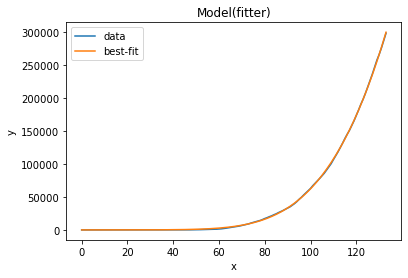

In [8]:
result.plot_fit(datafmt="-");

In [9]:
result.best_values

{'R_0_start': 3.644457898895501,
 'k': 0.037260452914693834,
 'x0': 56.0390160243485,
 'R_0_end': 1.2569232970972404}

In [10]:
pred=Model(total_days,**result.best_values)

In [11]:
pred_total=(pred[2][-7:]+pred[3][-7:]+pred[4][-7:])
mape_error=np.mean(np.abs(act_total-pred_total)/act_total)*100 

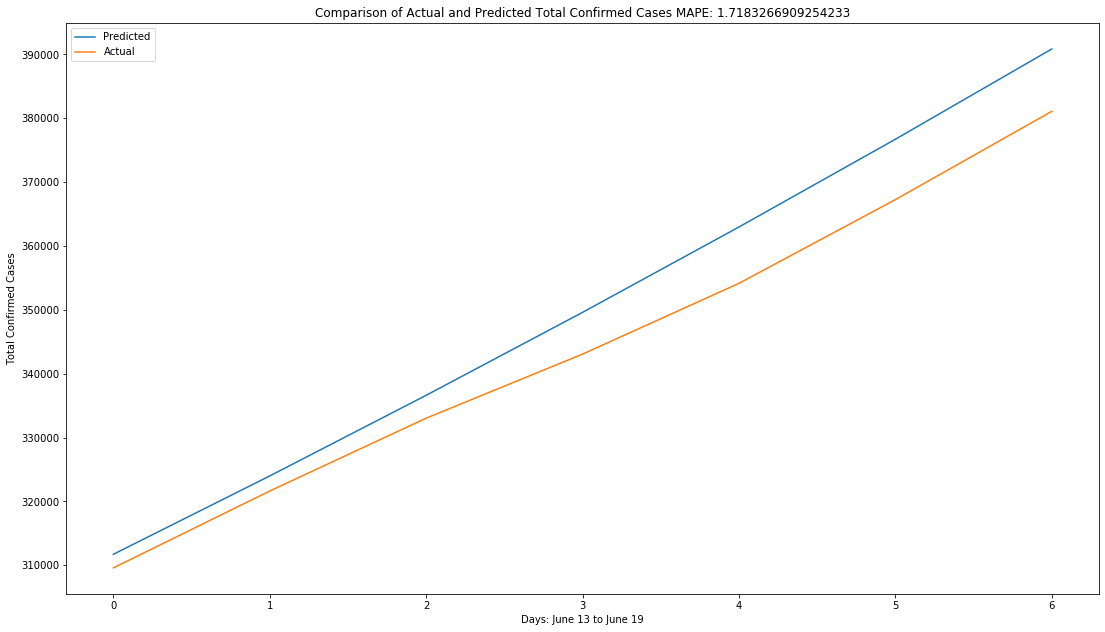

In [12]:
plt.plot(pred_total,label='Predicted')
plt.plot(act_total,label='Actual')
plt.ylabel('Total Confirmed Cases')
plt.xlabel("Days: June 13 to June 19")
plt.title("Comparison of Actual and Predicted Total Confirmed Cases MAPE: {}".format(mape_error))
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("results/{}.png".format(state))

In [13]:
np.mean(np.abs(act_total-pred_total)/act_total)*100 

1.7183266909254233